# Проект: классификация

In [637]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [612]:
df = pd.read_csv('/Users/kakotichi/Documents/GitHub/sf_data_science/Project_DS/project 4/bank_fin.csv', sep = ';')

In [559]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).
Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

In [561]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [562]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance      object
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

In [563]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [564]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [565]:
df = df.replace('balance')

In [566]:
def balance_float(x):
    if x is np.NaN:
        return np.NaN
    elif str(x)[0] == '0':
        return 0
    else:
        return int(str(x)[:-6].replace(' ', ''))


df['balance'] = df['balance'].apply(balance_float)

In [567]:
# вычислим среднее значение по преобразованному признаку  balance
df.mean(axis=0)

age           41.231948
balance     1529.129029
day           15.658036
duration     371.993818
campaign       2.508421
pdays         51.330407
previous       0.832557
dtype: float64

### Задание 4

In [568]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)

In [569]:
df.mean(axis=0)

age           41.231948
balance     1526.936033
day           15.658036
duration     371.993818
campaign       2.508421
pdays         51.330407
previous       0.832557
dtype: float64

### Задание 5

In [570]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])


In [571]:
job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: job if x == 'unknown' else x)

In [572]:
df.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.374063,1195.866567,15.340330,347.929535,2.376312,64.338831,0.973763
blue-collar,39.505144,1204.670267,15.235597,394.658951,2.541152,44.061214,0.633230
entrepreneur,42.887195,1621.942073,15.442073,370.182927,2.725610,32.746951,0.536585
housemaid,47.445255,1366.160584,16.364964,348.346715,2.689781,33.540146,0.503650
management,40.394537,1794.121017,15.783384,360.655918,2.593323,54.490137,0.919196
retired,65.424165,2412.019280,15.519280,389.993573,2.131105,53.003856,0.994859
self-employed,39.809877,1865.372840,15.938272,396.155556,2.533333,45.039506,0.804938
services,38.141928,1075.046587,15.728061,385.955580,2.576381,51.546046,0.684724
student,26.102778,1500.783333,15.175000,330.672222,2.169444,68.683333,1.297222


In [573]:
df.sort_values(by = 'education', ascending = False).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
5581,33,admin.,single,tertiary,no,2.0,no,no,cellular,29,jan,132,2,-1,0,unknown,no
3616,27,management,single,tertiary,no,1720.0,no,no,cellular,15,jun,910,1,224,3,success,yes
3638,49,management,married,tertiary,no,1167.0,yes,yes,cellular,25,jun,213,6,150,8,failure,yes
3637,37,self-employed,single,tertiary,no,1188.0,no,no,cellular,24,jun,310,1,-1,0,unknown,yes
3634,59,management,married,tertiary,no,5397.0,no,no,cellular,23,jun,671,3,-1,0,unknown,yes


In [574]:
df.sort_values(by = 'job', ascending = True).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
2154,24,admin.,single,tertiary,no,0.0,yes,no,cellular,27,may,122,2,-1,0,unknown,yes
8198,23,admin.,single,secondary,no,1104.0,yes,no,unknown,12,may,120,2,-1,0,unknown,no
2155,26,admin.,single,secondary,no,2509.0,no,no,cellular,27,may,776,3,97,3,success,yes
8202,42,admin.,married,primary,no,-466.0,no,yes,telephone,31,jul,94,15,-1,0,unknown,no


In [575]:
df_balance = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
print(round(df_balance['balance'].mean(), 3))


1598.883


### Задание 6

In [576]:
# удалите все выбросы для признака balance

def drop_iqr(df, col, left=1.5, right=1.5, log_scale=False, add_one=False):
    """Drop outliers using the interquartile range method (Tukey's method)

    Args:
        df (DataFrame): pandas DataFrame
        col (str): column name
        log_scale (bool, optional): converting to the natural log scale. 
                                    Defaults to False.
        add_one (bool, optional): add 1 to all values, 
                                  (works for the log scale only,
                                  usefull if there are zeros in data). 
                                  Defaults to False.
        left (float, optional): lower IQR bound. Defaults to 1.5.
        right (float, optional): upper IQR bound. Defaults to 1.5.

    Returns:
        tuple: a tuple containing the cleaned dataframe, the calculated 
               lower and upper bounds, and the dataframe with outliers
    """
    
    if log_scale and add_one:
        x = np.log(df[col]+1)
    elif log_scale and not add_one:
        x = np.log(df[col])
    else:
        x = df[col]
    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = df[(x<lower_bound) | (x>upper_bound)]
    clean_df = df[(x>=lower_bound) & (x<=upper_bound)]
    
    return clean_df, lower_bound, upper_bound, outliers


df, lower_bound, upper_bound, _ = drop_iqr(df, 'balance')
print(lower_bound, upper_bound, df.shape[0])

-2241.0 4063.0 10105


In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

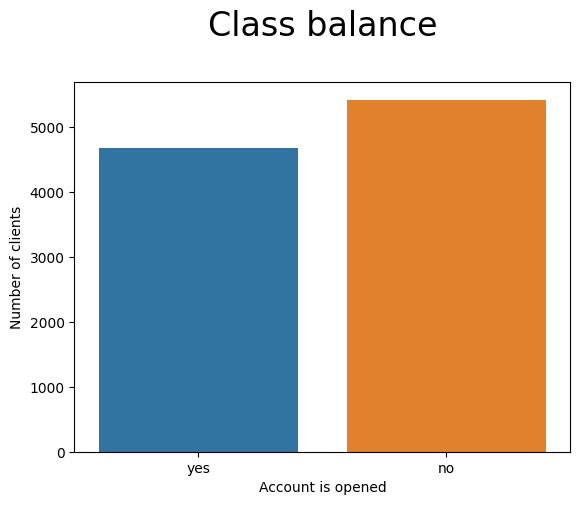

In [578]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts())
display(df['deposit'].value_counts(normalize=True))

ax = sns.countplot(x=df['deposit'])
ax.set(xlabel='Account is opened', ylabel='Number of clients')
ax.set_title('Class balance\n',fontsize=24);

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


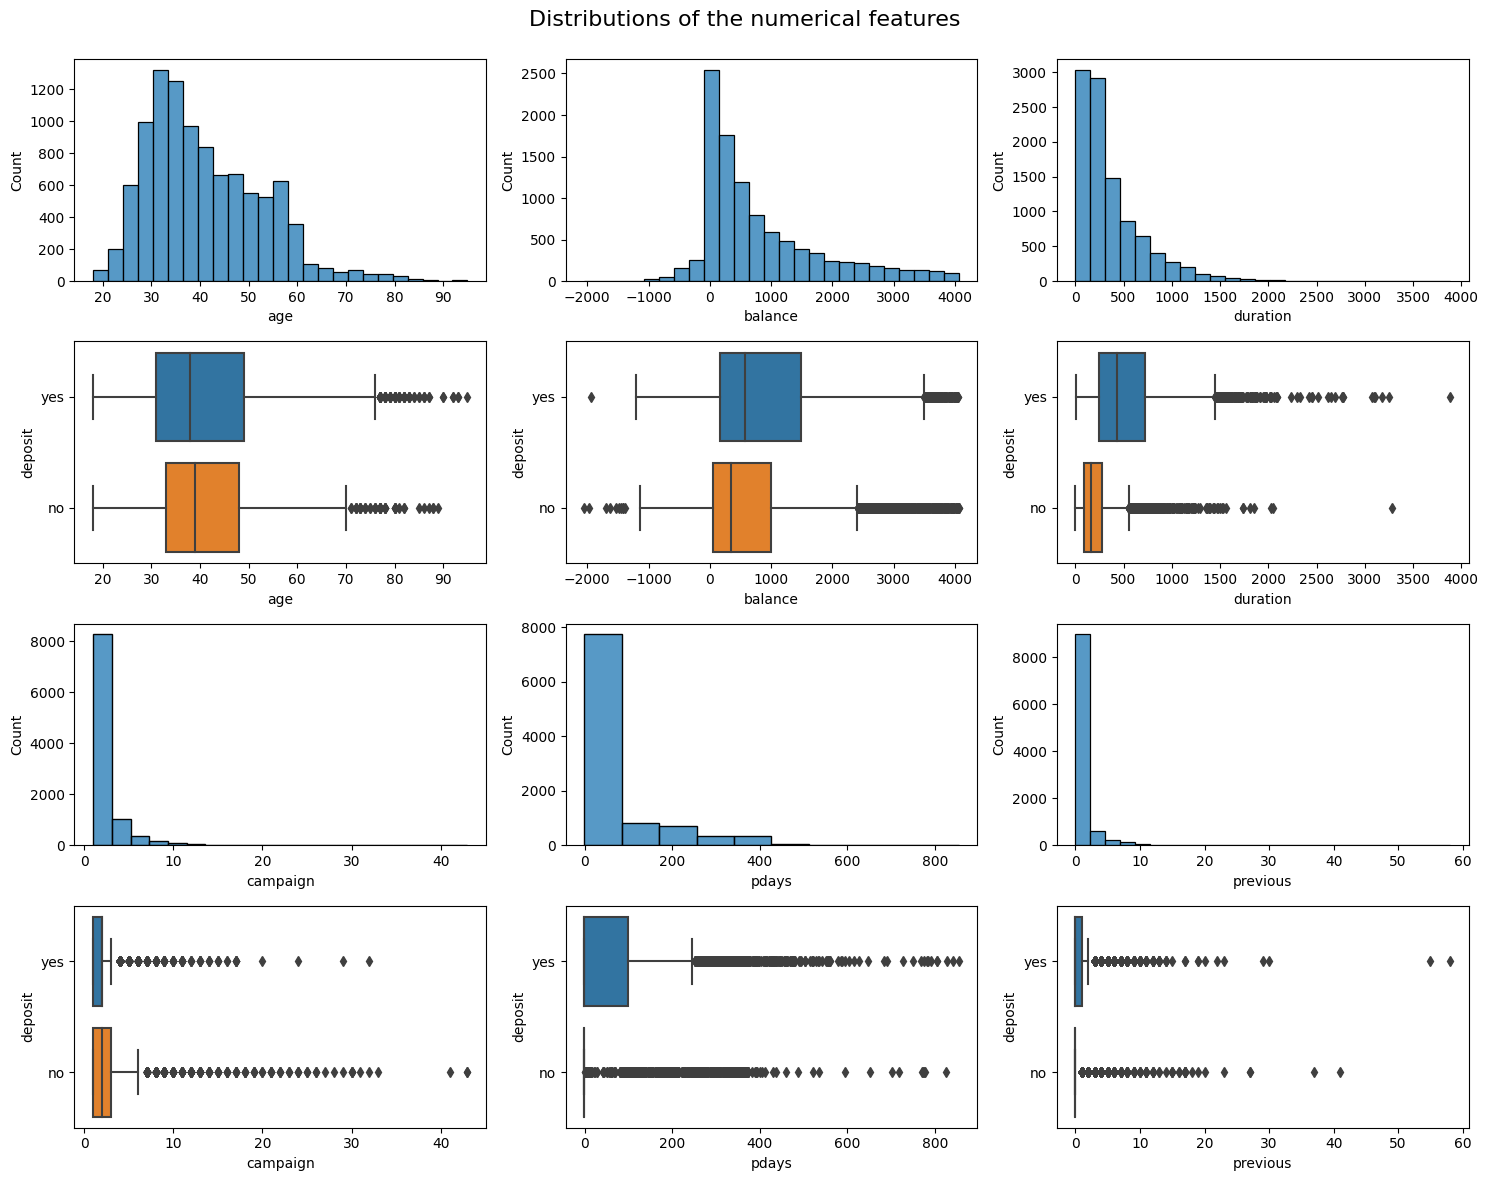

In [579]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
display(df.describe())

fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(df['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(df['balance'], bins=25, ax=ax[0,1])   # Баланс
sns.histplot(df['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(df['campaign'], bins=20, ax=ax[2,0])  # Количество контактов
sns.histplot(df['pdays'], bins=10, ax=ax[2,1])     # Количество дней после предыдущей кампании
sns.histplot(df['previous'], bins=25, ax=ax[2,2])  # Количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

# Общий вид распределения

- Возраст(age). Основной возраст клиентов от 30 до 50 лет. Далее мы наблюдаем резкое падение перед пенсионным возрастом.
- Баланс(balance). Тут можно наблюдать даже отрицательный баланс. Возможно это выброс. А так же мы наблюдаем небольшие балансы клиентов.
- Продолжительность контактов(duration). Средняя продолжительность контакта около 5 минут. Та же можно наблюдать выброс в виде 30 минут.
- Количество контактов (campaight). Выбросом будет являться более 15 контактов.
- Количество дней с момента предыдущей компании(pdays). Более 500 дней.
- Количество предыдущих контактов(previous). Выбросом будет более 15.

### Влияние на целевой признак

Вероятно всего на открытие депозита будет влиять такой фактор, как продолжительность контакта. Ведь чем он дольше, тем выше шанс. Но есть большое количесво контактов, то и верояность открытия депозита может равняться 0, т.к если контактировать с клиентом несколько раз не факт, что клиент может и согласиться. Так же на открытие депозита может повлиять большая сумма на счету у клиента. 

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


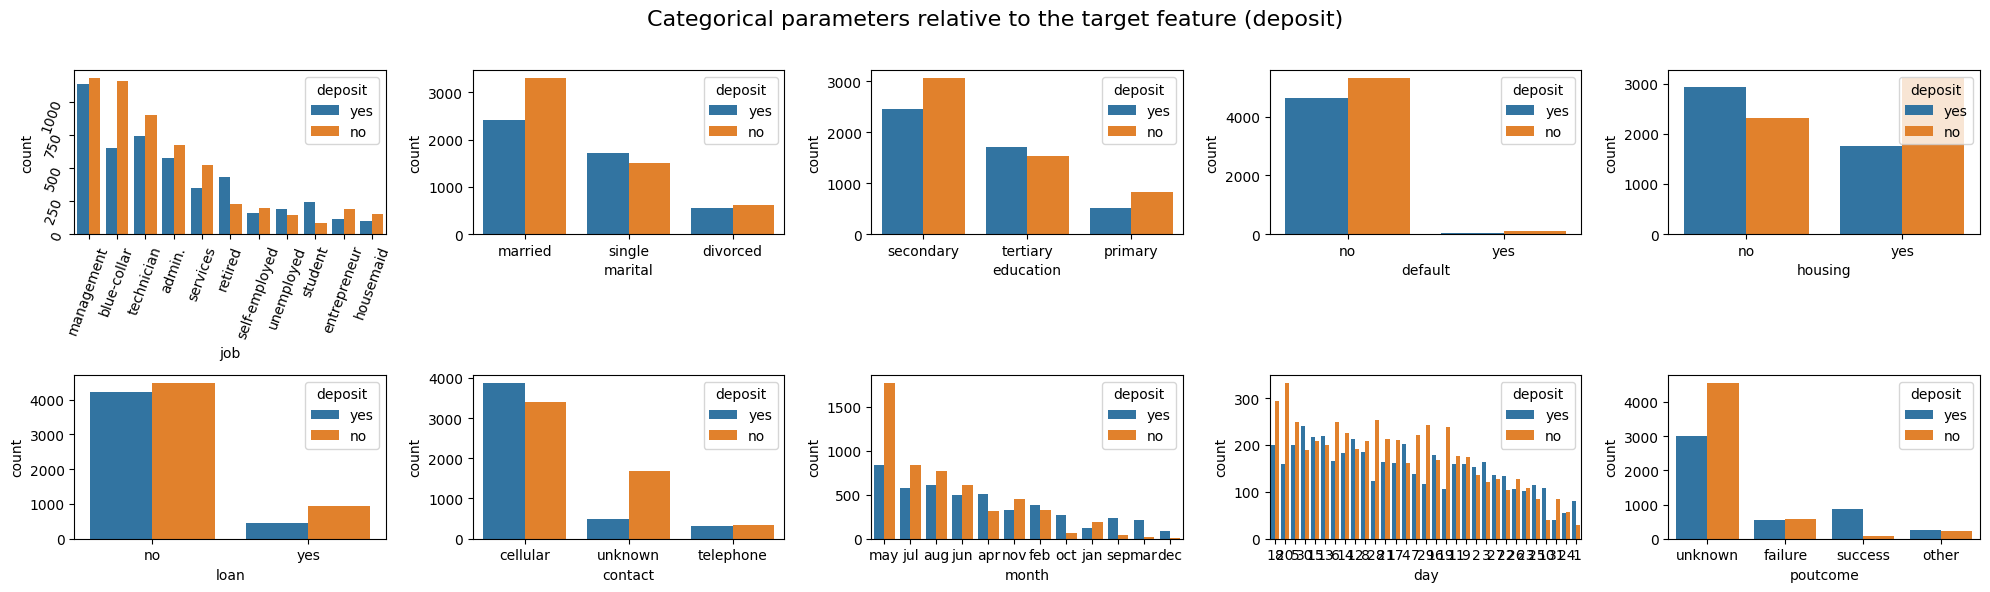

In [580]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include='object'))

fig, ax = plt.subplots(2,5, figsize=(20,6))


#Cфера занятости
sns.countplot(
    data=df, x='job', hue='deposit',
    order=df['job'].value_counts().index, ax=ax[0,0])

#Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[0,1])

#Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[0,2])

# Наличие просросроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[0,3])

# Имеется ли ипотека
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[0,4])

#Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[1,0])

#Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit',
    order=df['contact'].value_counts().index, ax=ax[1,1])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[1,2])

# День контакта
sns.countplot(
    data=df, x='day', hue='deposit',
    order=df['day'].value_counts().index, ax=ax[1,3])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[1,4])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()

На графиках мы видим разное соотношение депозитов на определенные факторы. Например:
- Студенты и пенсионеры чаще открывают депозит, чем другие категории, конечно их не так много как других категрий, но это имеет место быть.
- Женатые/незамужние, без итопеки открывают депозит.
- Клиенты с которыми связались по мобильному телефону.
- Клиенты которые согласились и в первый раз.

Кто точно не откроет депозит
- 'Синие воротнички'
- Люди с потребительскими кредитами


Еще можно наблюдать такую картину, в мае часто отказывают в открытии депозита, но в сентябре, октябре а так же в феврале, март, апреле его чаще отрывают.

### Задание 6

In [581]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
(df.groupby('month')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values('no', ascending=False) 

deposit,no,yes
month,,
may,67.863966,32.136034
jan,60.815047,39.184953
jul,58.956276,41.043724
nov,58.461538,41.538462
aug,55.956679,44.043321
jun,54.891304,45.108696
feb,45.557123,54.442877
apr,38.192771,61.807229
oct,18.507463,81.492537


### Задание 7

In [582]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts(normalize=True).unstack()

deposit,no,yes
month,,
apr,0.381928,0.618072
aug,0.559567,0.440433
dec,0.096774,0.903226
feb,0.455571,0.544429
jan,0.608150,0.391850
jul,0.589563,0.410437
jun,0.548913,0.451087
mar,0.101266,0.898734
may,0.678640,0.321360


### Задание 8

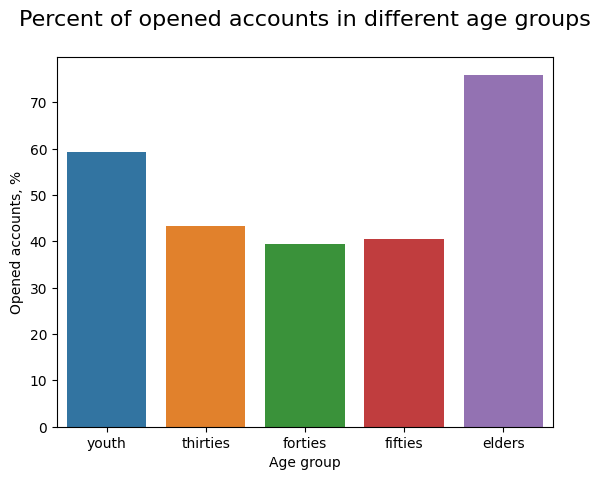

In [583]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(x):
    if x < 30:
        return 'youth'
    elif 30 <= x < 40:
        return 'thirties'
    elif 40 <= x < 50:
        return 'forties'
    elif 50 <= x < 60:
        return 'fifties' 
    else:
        return 'elders'   
    
    
    
df['age_group'] = df['age'].apply(age_group)
piv_tab = (df.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
ax = sns.barplot(
    data=piv_tab, x='age_group', y='yes', 
    order=['youth', 'thirties', 'forties', 'fifties', 'elders'])
ax.set(ylabel='Opened accounts, %', xlabel='Age group')
ax.set_title('Percent of opened accounts in different age groups\n', 
             fontsize=16);


### Задания 9 и 10

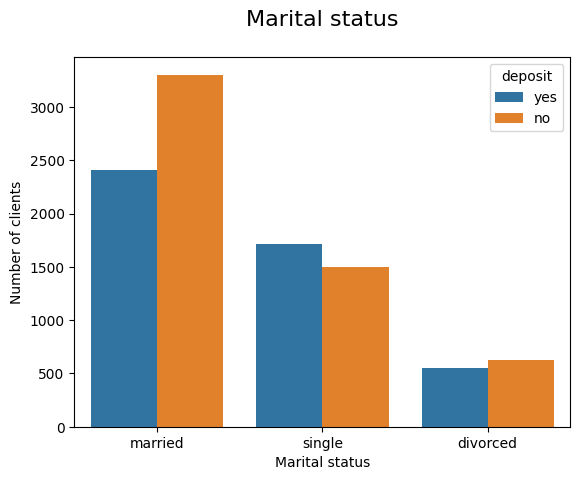

In [584]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ax = sns.countplot(data=df, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16);

Мы видим, что холостые более склоны к открытию депозита. Но более многочисленная группа люди имеющие семью.

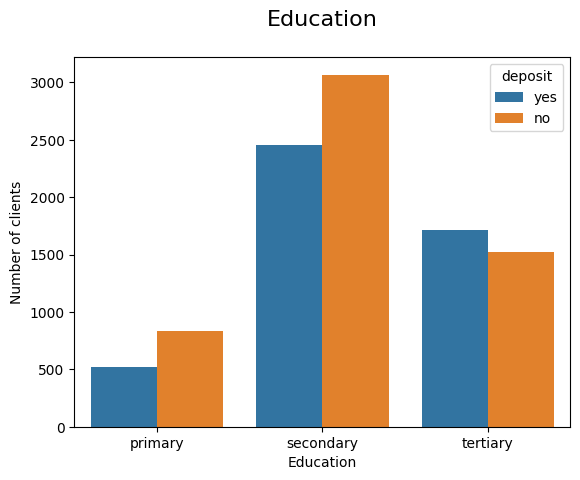

In [585]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ax = sns.countplot(data=df, x='education', hue='deposit',
                   order=['primary', 'secondary', 'tertiary'])
ax.set(xlabel='Education', ylabel='Number of clients')
ax.set_title('Education\n', fontsize=16);

Люди со среднем образованием более склоны к открытию депозита.

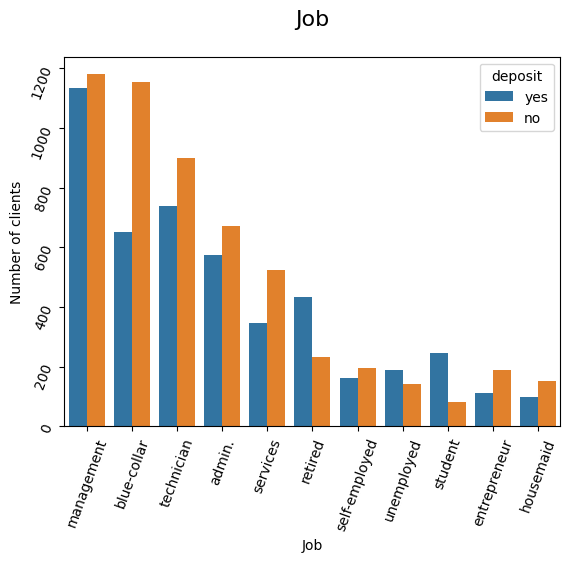

In [586]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
ax= sns.countplot(data=df, x='job', hue='deposit', 
              order=df['job'].value_counts().index)
ax.tick_params(labelrotation=70)
ax.set(xlabel='Job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16);

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


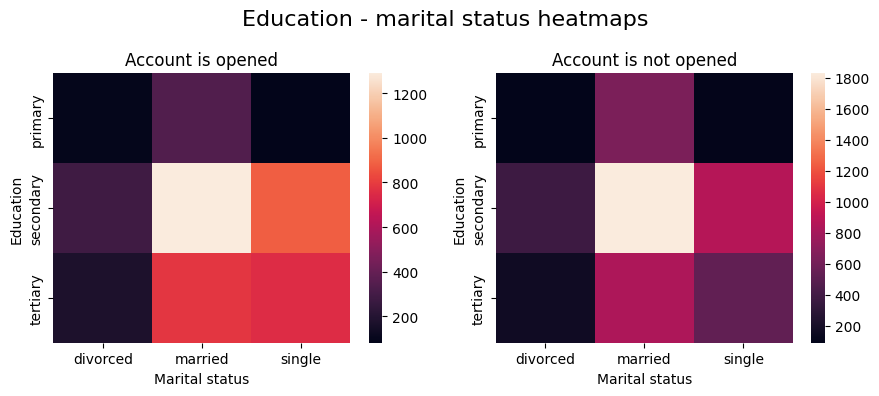

In [587]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
success = df[df['deposit']=='yes']
fail = df[df['deposit']=='no']
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()
## or:
#success_pivot = pd.pivot_table(success,     
#    index='education', columns='marital', values='age', aggfunc='count')  
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display(success_pivot, fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()

## Часть 3: преобразование данных

### Задание 1

In [588]:
# преобразуйте уровни образования
# Порядковое кодирование
# 0 - primary, 1 - secondary, 2 - tertiary
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])


In [589]:
# Создание экземпляра класса LabelEncoder()
lab_bin = LabelEncoder()

# Кодирование признака
df['education'] = lab_bin.fit_transform(df['education'])
df['education'].sum()

11995

In [590]:
# Кодируем признак age_range.
df['age'] = lab_bin.fit_transform(df['age'])

# Ответ на задание.
print('Сумма получившихся значений для признака education: {}'.format(df['education'].sum()))

Сумма получившихся значений для признака education: 11995


### Задания 2 и 3

In [591]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df.replace({'yes': 1, 'no': 0}, inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,41,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,fifties
1,38,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,fifties
2,23,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,forties
3,37,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,fifties
4,36,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,fifties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,15,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,thirties
11158,21,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,thirties
11159,14,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,thirties
11160,25,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,forties


In [614]:
# Перекодируем переменные в бинарный признак, где 'yes' - это 1, а 'no' - это 0.

# Кодирование депозита.
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование проссроченного кредита.
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование кредита на жилье.
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование кредита на личные нужды.
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

# Ответ на задание 2. Вычислить стандартное отклонение по преобразованной в корректный вид целевой переменной deposit
deposit_std = df['deposit'].std()
print('Стандартное отклонение депозита: {}'.format(round(deposit_std, 3)))

# Ответ на задание 3. Вычислить среднее арифметическое для каждой из получившихся переменных, сложить три результата и в качестве ответа подсчитать итог.
sum_cl = round((df['default'].mean() + df['housing'].mean() + df['loan'].mean()), 3)
print('Среднее арифметическое признаков default, housing и loan: {}'.format(sum_cl))

Стандартное отклонение депозита: 0.499
Среднее арифметическое признаков default, housing и loan: 0.619


### Задание 4

In [613]:
# Посчитаем, сколько теперь всего признаков в датасете. Посчитаем уже добавленные dummy-переменные, но до удаления номинальных.

# Список номинальных признаков.
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создание dummy-переменных.
clothing_dummies = pd.get_dummies(df[categorial_features])

# Объединение таблиц.
cleaned_concat = pd.concat([df, clothing_dummies], axis=1)

# Количесвто признаков.
print(f'Количество признаков: {cleaned_concat.shape[1]}')

Количество признаков: 51


In [615]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[[
    'job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, dummies], axis=1)

In [616]:

obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)
df

,age,default,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,1,0,5,1042,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
1,56,0,0,0,5,1467,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1,0,5,1389,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,55,0,1,0,5,579,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,54,0,0,0,5,673,2,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1,0,20,257,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11158,39,0,0,0,16,83,4,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
11159,32,0,0,0,19,156,2,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,0,0,1,8,9,2,172,5,0,...,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

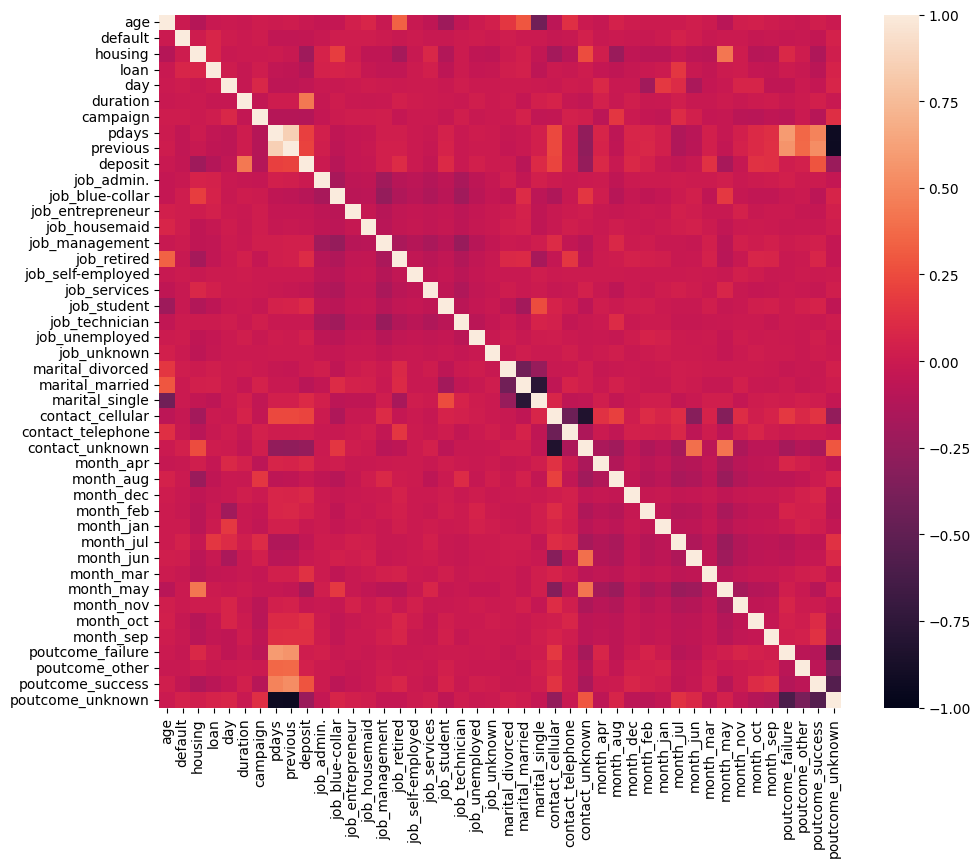

In [617]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_matrix = df.corr(method='kendall')

#Тепловая карта
fig = plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix, vmin=-1, vmax=1);

In [618]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


get_correlated(corr_matrix, thres=0.9)

previous -- poutcome_unknown   -0.937365
pdays -- poutcome_unknown      -0.924497
dtype: float64

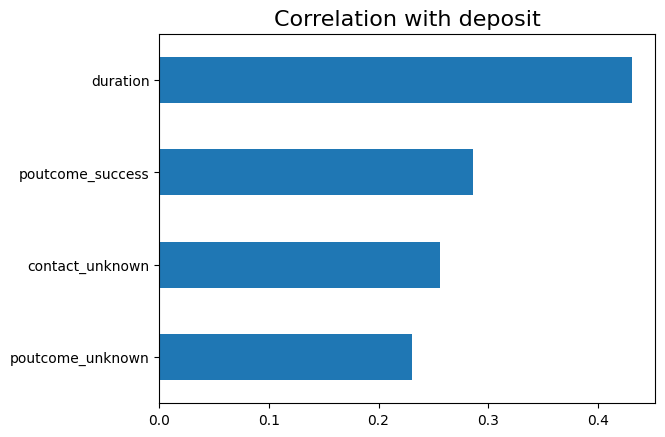

In [619]:

corr_matrix["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задания 7 и 8

In [620]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
df

,age,default,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,1,0,5,1042,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
1,56,0,0,0,5,1467,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1,0,5,1389,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,55,0,1,0,5,579,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,54,0,0,0,5,673,2,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1,0,20,257,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11158,39,0,0,0,16,83,4,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
11159,32,0,0,0,19,156,2,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,0,0,1,8,9,2,172,5,0,...,0,0,1,0,0,0,1,0,0,0


In [621]:
# рассчитайте необходимые показатели
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 7478
Размер тестовой выборки: 3684


### Задание 9

In [622]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Selected features:
 ['housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'job_blue-collar' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [625]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
df

,age,default,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,1,0,5,1042,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
1,56,0,0,0,5,1467,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1,0,5,1389,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,55,0,1,0,5,579,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,54,0,0,0,5,673,2,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1,0,20,257,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11158,39,0,0,0,16,83,4,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
11159,32,0,0,0,19,156,2,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,0,0,1,8,9,2,172,5,0,...,0,0,1,0,0,0,1,0,0,0


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [626]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
# Делаем предсказание для тренировочной выборки
y_test_pred = log_reg.predict(X_test)

# Делаем предсказание для тестовой выборки и вычисляем метрику accuracy.
accuracy_test = round(metrics.accuracy_score(y_test, y_test_pred), 2)
print('accuracy для тестовой выборки: {}'.format(accuracy_test))

accuracy для тестовой выборки: 0.81


### Задания 2,3,4

In [627]:
# обучите решающие деревья, настройте максимальную глубину
trees_data = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6, 
)

trees_data.fit(X_train, y_train)

y_train_pred = trees_data.predict(X_train)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = trees_data.predict(X_test)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.81
Test: 0.81


### Задание 5

In [631]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {
    'min_samples_split':[2, 5, 7, 10],
    'max_depth':[3,5,7]
}
# Вызываем класс GridSearchCV и передаем модель логистической регрессии 'LogisticRegression' и сетку искомых гиперпараметров 'param_grid'.
grid_search_1 = GridSearchCV(
    tree.DecisionTreeClassifier(
        random_state=42,
        ),
    param_grid=param_grid,  
    n_jobs = -1
)
# Обучаем дерево по алгоритму.
grid_search_1.fit(X_train, y_train)

# Выводим значение метрики F1 для тестовой выборки и значения наилучших гиперпараметров.
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [632]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
# Обучаем модель.
rf.fit(X_train, y_train)

# Делаем предсказание модели для тестовой выборки.
y_test_pred = rf.predict(X_test)

# Выводим значения метрики accuracy и recall для построенной модели на тестовой выборке.
print('Метрика accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Метрика recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Метрика accuracy на тестовой выборке: 0.83
Метрика recall на тестовой выборке: 0.85


### Задания 2 и 3

In [639]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# Создаем список базовых моделей в виде кортежей вида (наименование модели, модель).

gb = GradientBoostingClassifier(
    learning_rate=0.05, # темп обучения
    n_estimators=300, # число деревьев
    max_depth=5, # максимальная глубина дерева
    min_samples_leaf = 5, # количество листьев
    random_state=42 # генератор случайных чисел
)
# Обучаем модель.
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки.
y_test_pred = gb.predict(X_test)

# Посмотрим на метрику классификации F1 для тестовой выборки.
print('f1_score на тестовом наборе после градиентного бустинга: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе после градиентного бустинга: 0.82


### Задание 4

In [640]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список базовых моделей в виде кортежей вида (наименование модели, модель).
estimators = [
    ('lg', linear_model.LogisticRegression(
        solver='sag', # алгоритм оптимизации
        random_state=42, # генератор случайных чисел
        max_iter=1000)), # количество итераций на сходимость
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy', # энтропия
        random_state=42,
        max_depth=6)), # глубина дерева
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, # темп обучения
        n_estimators=300, # число деревьев
        max_depth=5, # максимальная глубина дерева
        min_samples_leaf = 5, # количество листьев
        random_state=42))
]
# Создаем объект класса стекинг.
reg = StackingClassifier(
    estimators = estimators, # базовые модели в стекинге
    final_estimator = linear_model.LogisticRegression(random_state=42) # метамодель
)
# Обучаем модель.
reg.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки.
y_test_pred = reg.predict(X_test)

# Выводим значение метрики precision для построенной модели на тестовой выборке.
print('Метрика precision на тестовой выборке: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Метрика precision на тестовой выборке: 0.81


### Задание 5

In [647]:
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)
sorted(list(zip(selected_cols, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)



[('duration', 0.5450570617777926),
 ('poutcome_success', 0.10474298186011013),
 ('contact_unknown', 0.08829323759712669),
 ('pdays', 0.06803309169808408),
 ('housing', 0.04812252392382337),
 ('month_mar', 0.03145566668884046),
 ('campaign', 0.026488352345558908),
 ('month_oct', 0.021294075261162285),
 ('loan', 0.015969436336736573),
 ('month_may', 0.013902733402989172),
 ('job_blue-collar', 0.011900909159127072),
 ('previous', 0.009719384882772658),
 ('month_sep', 0.009092119498444582),
 ('contact_cellular', 0.00503034402551135),
 ('poutcome_unknown', 0.0008980815419202634)]

Было найдено 3 лучших признака: 'duration', 'contact_unknown', 'poutcome_success'.

Признак duration (продолжительность контакта) имеет наибольшую важность, т.к очень важно что продолжительсть звонка влияет на решение клиента об открытии депозита. Ведь очень важен индивидуальный подход к каждому клиенту, а это времени затратно.
Признак contact_unknown (тип контакта со значением "неизвестно") так же оказывает большое влияние. Данное значение, вероятнее всего, показывает, что контакт с клиентом не состоялся. Если это так, то клиенту не поступало предложение от банка и поэтому он не открыл депозит.

Признак 'poutcome_success' (успешный результат прошлой маркетинговой компании) тоже оказывает большое влияние на открытие депозита. Если клиент открыл в прошлом депозит в этом банке, то вероятнее всего он снова откроет его, так как он уже является клиентом этого банка и он доверяет этому банку и знаком с его условиями. Этому способствует и простота открытия депозита, поэтому клиент не уйдет из банка, а будет пользоваться услугами банка.

In [651]:
# Фиксируем random_state
random_state = 42
def optuna_rf(trial):
    # Задаем пространства поиска гиперпараметров.
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем объект класса случайного леса.
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state
    )
    #  Обучаем модель.
    model.fit(X_train, y_train)
    
    # Вычисляем метрику F1 на тестовой выборке.
    y_test_predict = model.predict(X_test)
    score = metrics.f1_score(y_test, y_test_predict)

    return score

# Создаем объект исследования. Указываем, что нам нужно максимизировать метрику 'maximize'.
study = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

# Находим лучшую комбинацию гиперпараметров.
study.optimize(optuna_rf, n_trials = 20)

# Выводим результаты на обучающей выборке.
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(study.best_value))

[I 2023-06-21 00:09:44,621] A new study created in memory with name: RandomForestClassifier
[I 2023-06-21 00:09:45,362] Trial 0 finished with value: 0.8125870231133389 and parameters: {'n_estimators': 198, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8125870231133389.
[I 2023-06-21 00:09:45,811] Trial 1 finished with value: 0.825405707890319 and parameters: {'n_estimators': 182, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.825405707890319.
[I 2023-06-21 00:09:46,266] Trial 2 finished with value: 0.825405707890319 and parameters: {'n_estimators': 184, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.825405707890319.
[I 2023-06-21 00:09:46,720] Trial 3 finished with value: 0.8259653049804141 and parameters: {'n_estimators': 183, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8259653049804141.
[I 2023-06-21 00:09:47,170] Trial 4 finished with value: 0.8142777467930842 and parameters: {'n_esti

Наилучшие значения гиперпараметров {'n_estimators': 154, 'max_depth': 13, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83
